### Paxillin movie segmentation and object feature analysis

with static images

Liya Ding, 2024.04

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import umap
from joblib import dump, load
import os.path

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.transforms import Bbox

import tifffile 
import czifile

import skimage
from skimage.morphology import remove_small_objects
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb

from scipy import ndimage
from scipy.ndimage import distance_transform_cdt
from scipy.ndimage import gaussian_filter

from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# function from aicssegmentation tool
from utils.vessel_2d import filament_2d_wrapper
from utils.pre_processing_utils import intensity_normalization


In [2]:
czimovie_dir =  '/mnt/d/lding/FA/data/FHL2-KI-U2OS-Actin405-Pax568-endoFHL2488_annabel_20240226'

csv_output_dir = '/mnt/d/lding/FA/analysis_results/pax_3D/pax_3D_0226/SM_Vess-LocThr-GlThr-Dots_csv'
plot_output_dir = '/mnt/d/lding/FA/analysis_results/pax_3D/pax_3D_0226/SM_Vess-LocThr-GlThr-Dots_plot'
seg_output_dir = '/mnt/d/lding/FA/analysis_results/pax_3D/pax_3D_0226/SM_Vess-LocThr-GlThr-Dots_seg'

pixel_size = 0.0706
time_point = 0

if not os.path.isdir(csv_output_dir):
    os.makedirs(csv_output_dir)
if not os.path.isdir(plot_output_dir):
    os.makedirs(plot_output_dir)
if not os.path.isdir(seg_output_dir):
    os.makedirs(seg_output_dir)

In [3]:
# build the colormap with iterative tab10
tab10 = cm.get_cmap('tab10', 10)
for i in range(10):
    tab10.colors = np.concatenate([tab10.colors,tab10.colors],axis=0)    
tab10.colors = np.concatenate([np.zeros([1,4]),tab10.colors],axis=0)

newmap = cm.get_cmap('tab10', 4000+1)
newmap.colors = tab10.colors[0:4000+1,:]
newmap.colors[0,:]  = np.ones([1,4])
newmap.colors[0,3] = 1

### for each movie run through all the time points

In [4]:
# flag for some optinal parts
flag_plot = True
flag_plot_save = True
flag_seg_save = True
flag_csv_save = True
flag_run_all = True
flag_panel_plot = True

In [5]:
csv_output_dir = '/mnt/d/lding/FA/analysis_results/static_image_csv'
prop_df_pax_all = pd.read_csv(os.path.join(csv_output_dir,'pax_moredots_lessfea_static_images_cluster_labels_allcells_nc4.csv'))
     

(-11.95793855, 16.429069549999998, -6.800026725, 14.634820224999999)

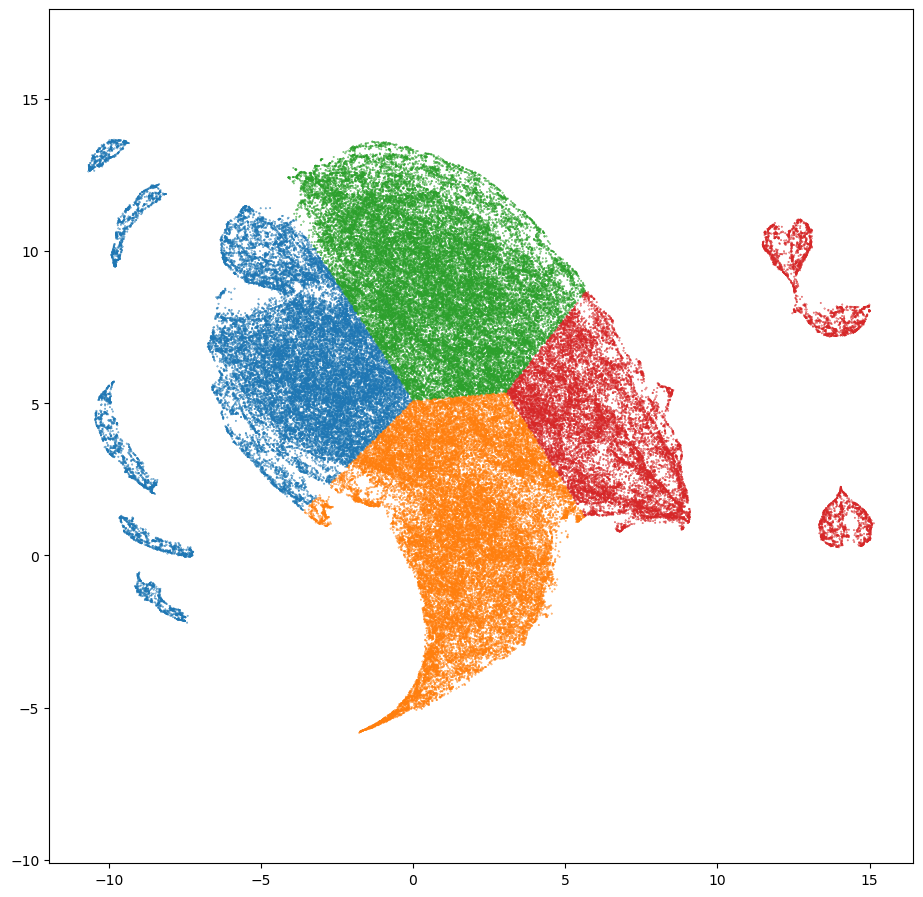

In [8]:
plt.figure(figsize=(9, 9))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)
plt.scatter( prop_df_pax_all['U0'],prop_df_pax_all['U1'], s=0.1, color=newmap.colors[prop_df_pax_all['cluster_ID_MiniBatc']+1,:])
plt.axis('equal')

In [9]:
### for each movie, make sub-folders for different output for easier viewing in imagej
movie_mask_output_dir = os.path.join(seg_output_dir,  'mask')
movie_seg_output_dir = os.path.join(seg_output_dir,  'seg')
movie_label_output_dir = os.path.join(seg_output_dir,  'label')
movie_labeltoggle_output_dir = os.path.join(seg_output_dir,  'togglelabel')
movie_rgb_output_dir = os.path.join(seg_output_dir,  'rgb')    
movie_contour_output_dir = os.path.join(plot_output_dir,  'contour')
movie_quiver_cell_output_dir = os.path.join(plot_output_dir,  'quiver_cell')
movie_quiver_obj_output_dir = os.path.join(plot_output_dir,  'quiver_obj')
movie_label_color_output_dir = os.path.join(plot_output_dir,  'label_color')
movie_rgb_plot_output_dir = os.path.join(plot_output_dir,  'rgb_plot')
movie_panels_plot_output_dir = os.path.join(plot_output_dir,  'panel_plot')
movie_cluster_plot_output_dir = os.path.join(plot_output_dir,  'cluster_nc4_moredotslessfea_Spectral_plot')
if not os.path.isdir(movie_cluster_plot_output_dir):   os.makedirs(movie_cluster_plot_output_dir)

In [47]:
filenames = [x for x in os.listdir(czimovie_dir) if os.path.isfile(os.path.join(czimovie_dir, x)) and ('.czi' in x)]


In [50]:
filenames[40:]

['Control 8.czi',
 'Control 9.czi',
 'Contrrol 38.czi',
 'Contrrol 42.czi',
 'Contrrol 6.czi',
 'Rock 24hr 1.czi',
 'Rock 24hr 2-1.czi',
 'Rock 24hr 2-2.czi',
 'Rock 24hr 3.czi',
 'Rock 24hr 4.czi',
 'Rock 24hr 5.czi',
 'Rock 30 min 2.czi',
 'Rock 30min 1.czi',
 'Rock 30min 3.czi',
 'Rock 30min 4.czi',
 'Rock 30min 5.czi']

In [52]:
filenames = [x for x in os.listdir(czimovie_dir) if os.path.isfile(os.path.join(czimovie_dir, x)) and ('.czi' in x)]

# if not in run all mode, only test with the first image of the first movie
if not flag_run_all:
    filenames = filenames[0:1]

for filenameID in range(40,len(filenames)):
    filename = filenames[filenameID]
    img = czifile.imread(os.path.join(czimovie_dir,filename))
    pax_img = img[0,0,0,:,:,:,0].squeeze()
    intensity_scaling_param = [10,40]
    norm_pax_img = intensity_normalization(pax_img, scaling_param=intensity_scaling_param)
    MIP_pax_img = norm_pax_img.max(axis=0)
    label_pax_seg = tifffile.imread(os.path.join(movie_label_output_dir, 'SS_pax_seglabel_'+filename+'_MIP'+'.tif'))   

    max_label = label_pax_seg.max()+1

    
    # print(newmap.colors[:,0:3])
    less_col_prop_df_pax_all = prop_df_pax_all[['filename','cell_ID','label','area','eccentricity','mean_intensity','cluster_ID_MiniBatc']]
    cluster_label_pax_seg = np.zeros_like(label_pax_seg)
    this_cell_table = less_col_prop_df_pax_all[less_col_prop_df_pax_all['filename'] == filename]


    fig = plt.figure(figsize=(20,20), dpi=512)
    fig, ax = plt.subplots(1,2, figsize=(40,20), dpi=256, facecolor='w', edgecolor='k')
    ax[0] = fig.add_subplot(1,2,1,projection='3d')
    # ax[0].scatter(
    #         prop_df_pax_all['area'],
    #         prop_df_pax_all['eccentricity'],
    #         prop_df_pax_all['mean_intensity'], s=0.1, color=newmap.colors[prop_df_pax_all['cluster_ID_MiniBatc'].to_numpy()+1,:].squeeze())
    ax[0].scatter(
            this_cell_table['area'],
            this_cell_table['eccentricity'],
            this_cell_table['mean_intensity'], s=30, marker='o', color=newmap.colors[this_cell_table['cluster_ID_MiniBatc'].to_numpy()+1,:].squeeze())
    ax[0].set_xlim(0,1000)
    ax[0].set_ylim(0,1)
    ax[0].set_zlim(0.4,0.9)    

    
    for iL in range(1,label_pax_seg.max()+1):  
        # print(iL)
        cluster_ID = this_cell_table[this_cell_table['label']==iL]        
        if(cluster_ID.shape[0]==1):
            cluster_label_pax_seg[label_pax_seg==iL] = cluster_ID.iloc[0,-1]+1
        
    ax[1].imshow(cluster_label_pax_seg, cmap=newmap,vmax = 4001,vmin = 0, interpolation='none')
    ax[1].axis('off')
        
    tifffile.imsave(os.path.join(movie_cluster_plot_output_dir, 'label_clusters_'+filename+'_MIP'+'.tif'),cluster_label_pax_seg.astype(np.uint16)) 

    # save the plots and subplots for easier viewing
    plt.savefig(os.path.join(movie_cluster_plot_output_dir,'VB_clusters_'+str(filenameID)+'.png'))

    plt.close(fig) 
                    

                

<Figure size 10240x10240 with 0 Axes>

<Figure size 10240x10240 with 0 Axes>

<Figure size 10240x10240 with 0 Axes>

<Figure size 10240x10240 with 0 Axes>

<Figure size 10240x10240 with 0 Axes>

<Figure size 10240x10240 with 0 Axes>

<Figure size 10240x10240 with 0 Axes>

<Figure size 10240x10240 with 0 Axes>

<Figure size 10240x10240 with 0 Axes>

<Figure size 10240x10240 with 0 Axes>

<Figure size 10240x10240 with 0 Axes>

<Figure size 10240x10240 with 0 Axes>

<Figure size 10240x10240 with 0 Axes>

<Figure size 10240x10240 with 0 Axes>

<Figure size 10240x10240 with 0 Axes>

<Figure size 10240x10240 with 0 Axes>

In [ ]:
columns=['area', 'bbox_area', 'convex_area', 'eccentricity', 'equivalent_diameter', 'euler_number',
                    'extent','filled_area','label','major_axis_length','max_intensity','mean_intensity',
                    'min_intensity','minor_axis_length','orientation','perimeter','solidity',
                    'cell_edge_dist','cell_edge_orient','diff_orient']

In [6]:
columns=['area', 'bbox_area','major_axis_length','max_intensity','mean_intensity',
                    'min_intensity','minor_axis_length',
                    'cell_edge_dist','cell_edge_orient','diff_orient']

In [9]:
prop_df_pax_all['minor_axis_length'] = prop_df_pax_all['minor_axis_length']*0.0706

In [7]:
prop_df_pax_all['area'] = prop_df_pax_all['area']*0.0706*0.0706
prop_df_pax_all['bbox_area'] = prop_df_pax_all['bbox_area']*0.0706*0.0706
prop_df_pax_all['major_axis_length'] = prop_df_pax_all['major_axis_length']*0.0706
prop_df_pax_all['minor_axis_length'] = prop_df_pax_all['minor_axis_length']*0.0706
prop_df_pax_all['cell_edge_dist'] = prop_df_pax_all['cell_edge_dist']*0.0706

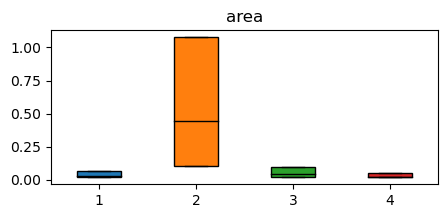

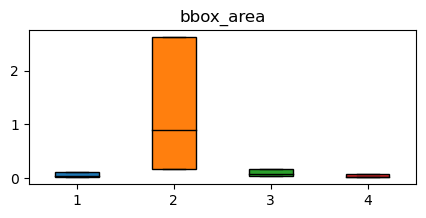

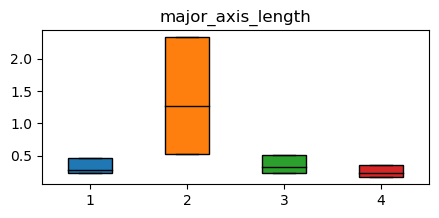

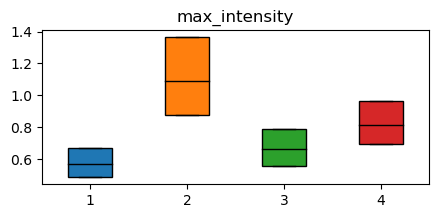

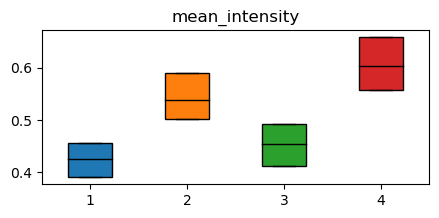

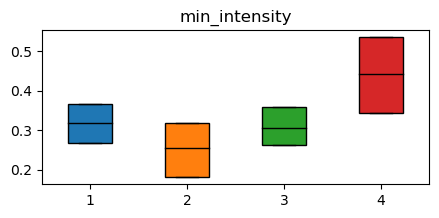

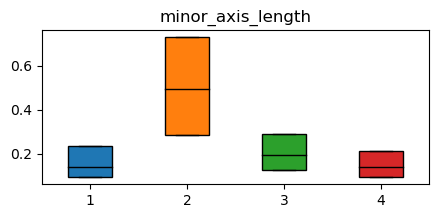

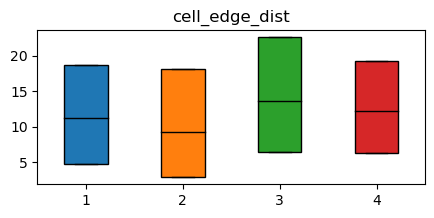

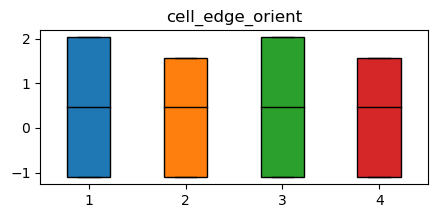

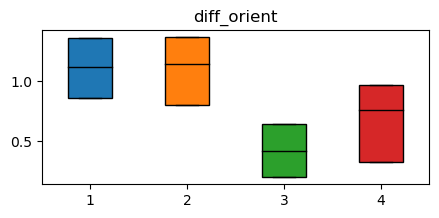

In [10]:
for clusterMed in ['MiniBatc']:
   for featureName in columns:   
        
        AA=[None] * 4 
        for i in range(4):
            temp = (prop_df_pax_all[prop_df_pax_all['cluster_ID_'+clusterMed]==i])
            AA[i]=temp[featureName]
        
        

        fig, ax = plt.subplots(1, 1, figsize=(5,2))
        
        box = ax.boxplot(AA, whis=(25, 75),showfliers=False,patch_artist=True)  # patch_artist=True enables coloring

        # Apply colors to each box
        for patch, color in zip(box['boxes'], newmap.colors[1:5, :]):
            patch.set_facecolor(color)

        for median in box['medians']:
            median.set_color('black')
            
        ax.set_title(featureName )

        #     boxfig = ax[i].boxplot(AA[featureName],showfliers=False,boxprops={'color':newmap.colors[i+1,:]})
        #     ax[i].set_ylim([np.percentile(prop_df_pax_all[featureName],0.01),np.percentile(prop_df_pax_all[featureName],95)])
        #     ax[i].set_xlabel('C'+str(i))
        #     ax[i].set_xticks(())
        #     for median in boxfig['medians']:
        #         median.set_color(newmap.colors[i+1,:])
        # ax[2].set_title(featureName )

        # fig.savefig(os.path.join('/mnt/d/lding/FA/analysis_results/static_clustering_stats', 'pax_moredotslessfea_nc4_stat_'+featureName + '_' +clusterMed+'.png'))
            

In [31]:
AA

[0         74
 1          6
 4         85
 6         12
 8         26
           ..
 119721     4
 119727     3
 119728    13
 119733    17
 119735     3
 Name: area, Length: 29707, dtype: int64,
 None,
 None,
 None]

In [28]:
AA

[        Unnamed: 0            filename  cell_ID  time_point  area  bbox_area  \
 0                0  MAX_C2-Cell-01.tif        0           0    74        208   
 1                1  MAX_C2-Cell-01.tif        0           0     6          9   
 4                4  MAX_C2-Cell-01.tif        0           0    85        232   
 6                6  MAX_C2-Cell-01.tif        0           0    12         30   
 8                8  MAX_C2-Cell-01.tif        0           0    26         63   
 ...            ...                 ...      ...         ...   ...        ...   
 119721        2646    Rock 30min 5.czi       55           0     4          6   
 119727        2652    Rock 30min 5.czi       55           0     3          3   
 119728        2653    Rock 30min 5.czi       55           0    13         20   
 119733        2658    Rock 30min 5.czi       55           0    17         45   
 119735        2660    Rock 30min 5.czi       55           0     3          4   
 
         convex_area  ecce

In [26]:
AA

[        Unnamed: 0            filename  cell_ID  time_point  area  bbox_area  \
 0                0  MAX_C2-Cell-01.tif        0           0    74        208   
 1                1  MAX_C2-Cell-01.tif        0           0     6          9   
 4                4  MAX_C2-Cell-01.tif        0           0    85        232   
 6                6  MAX_C2-Cell-01.tif        0           0    12         30   
 8                8  MAX_C2-Cell-01.tif        0           0    26         63   
 ...            ...                 ...      ...         ...   ...        ...   
 119721        2646    Rock 30min 5.czi       55           0     4          6   
 119727        2652    Rock 30min 5.czi       55           0     3          3   
 119728        2653    Rock 30min 5.czi       55           0    13         20   
 119733        2658    Rock 30min 5.czi       55           0    17         45   
 119735        2660    Rock 30min 5.czi       55           0     3          4   
 
         convex_area  ecce

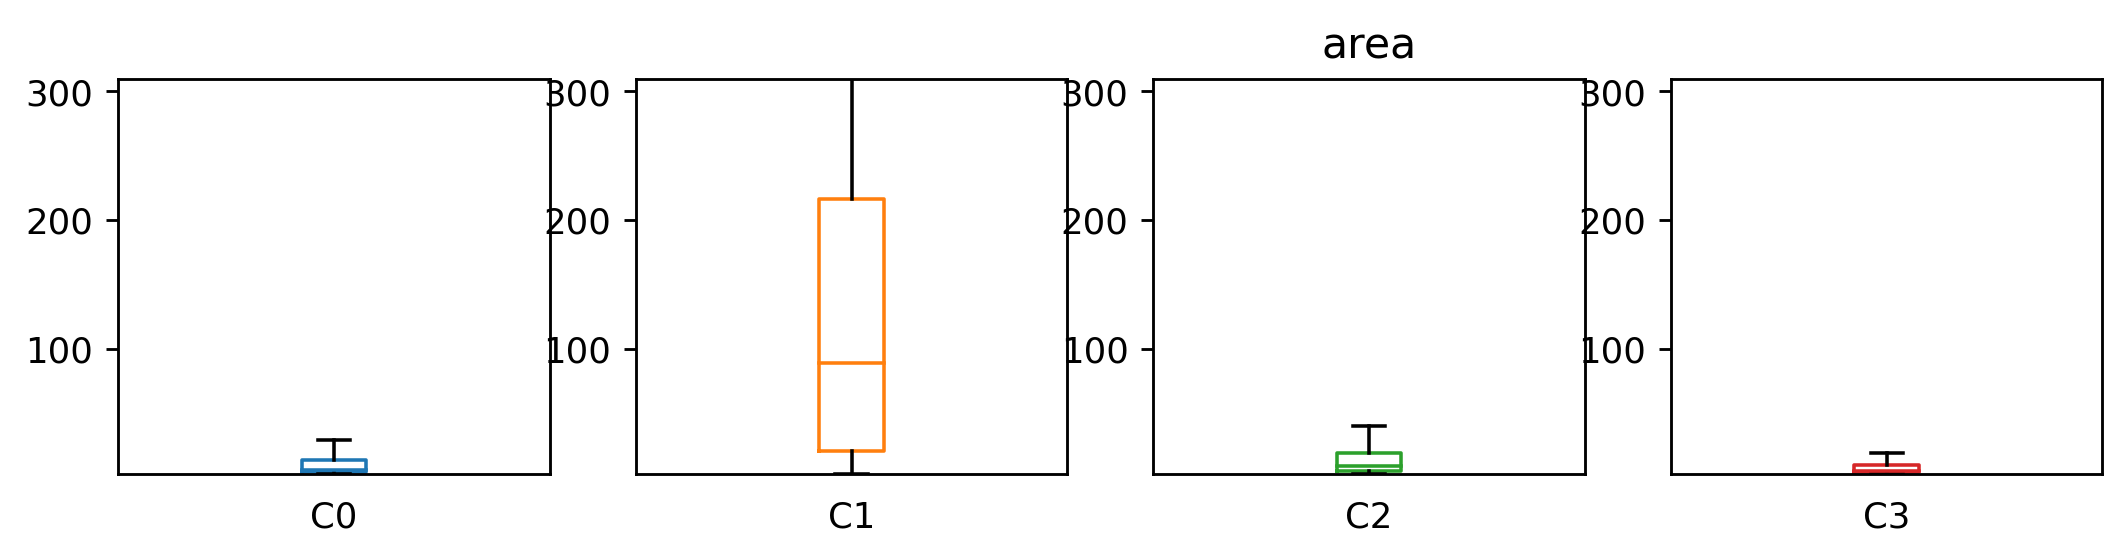

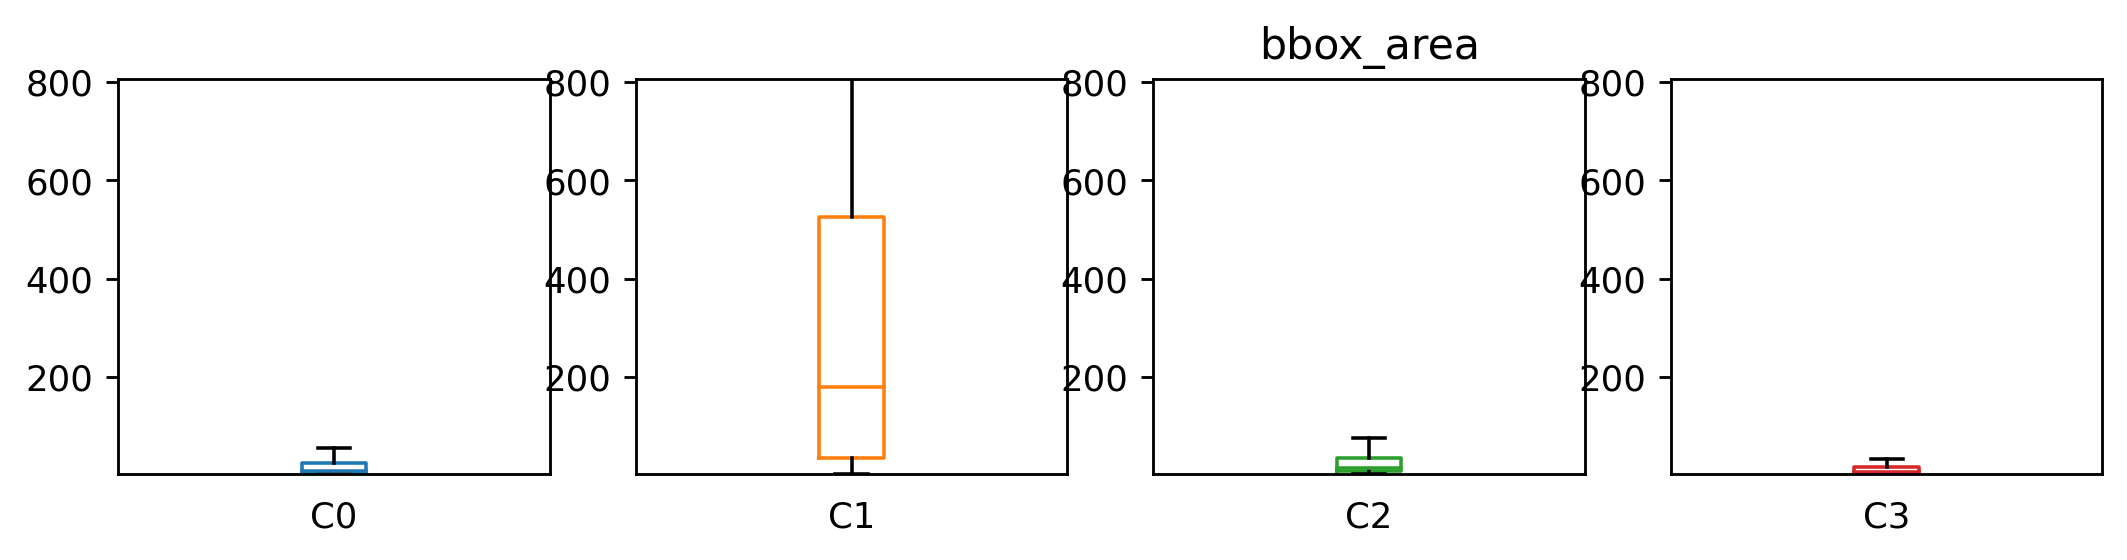

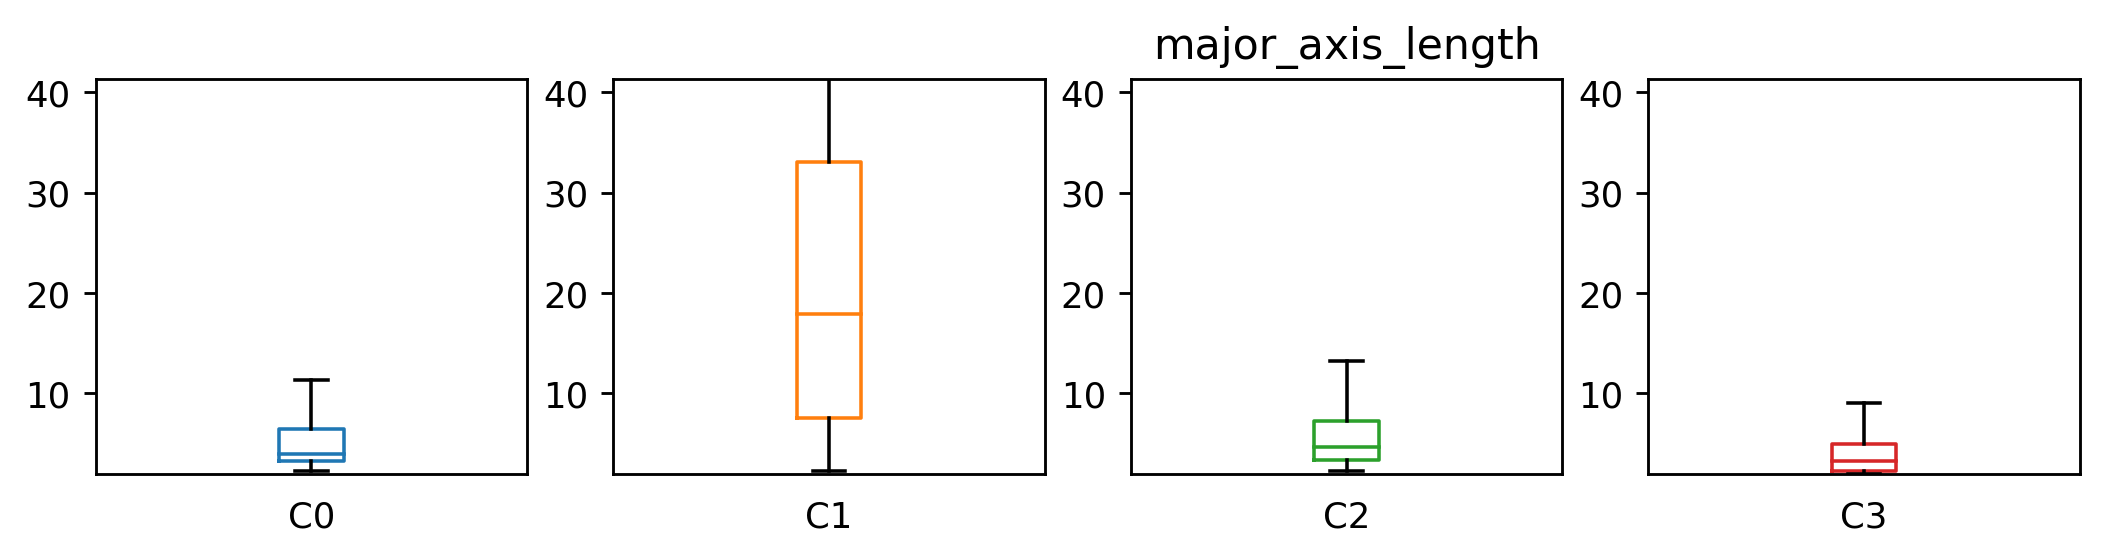

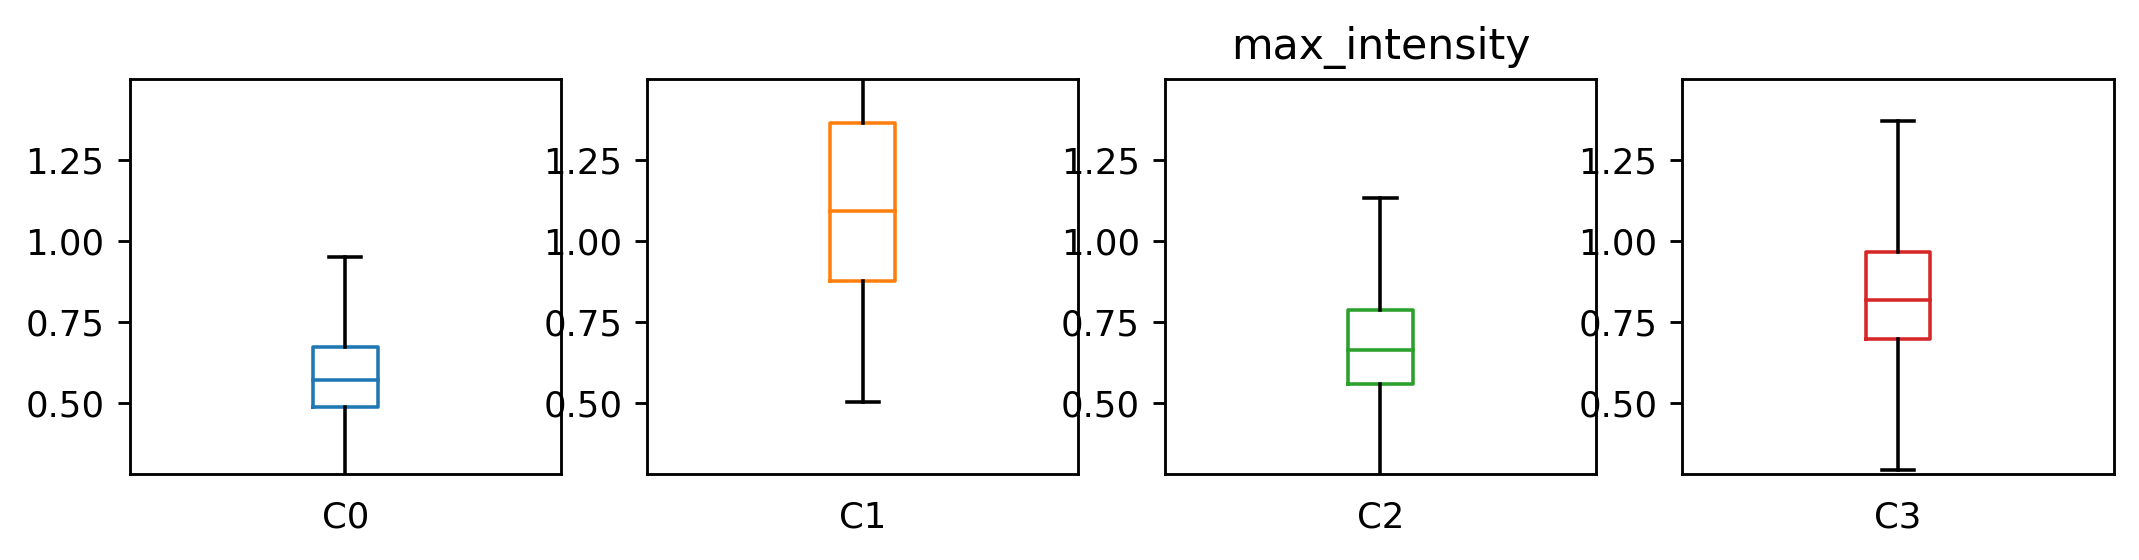

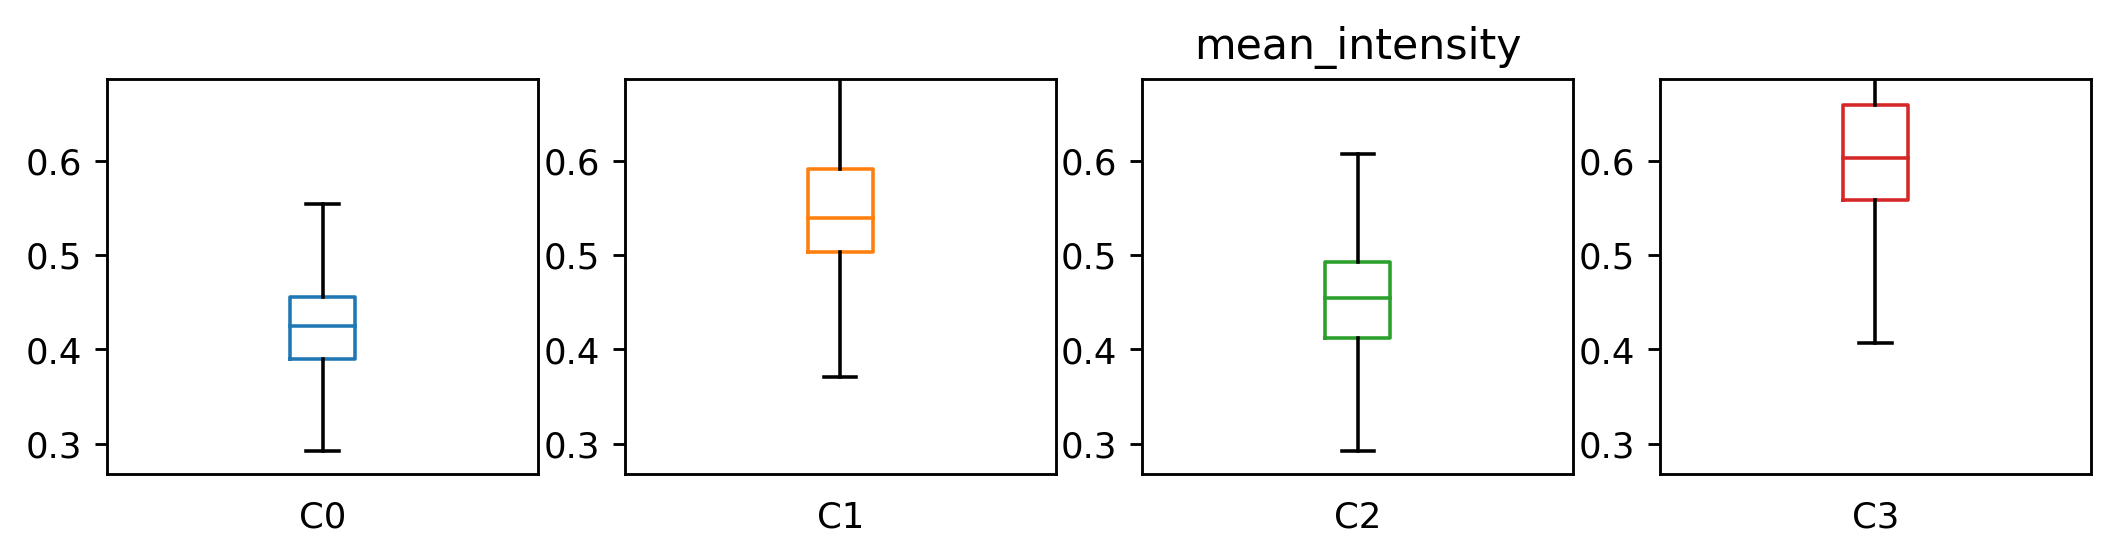

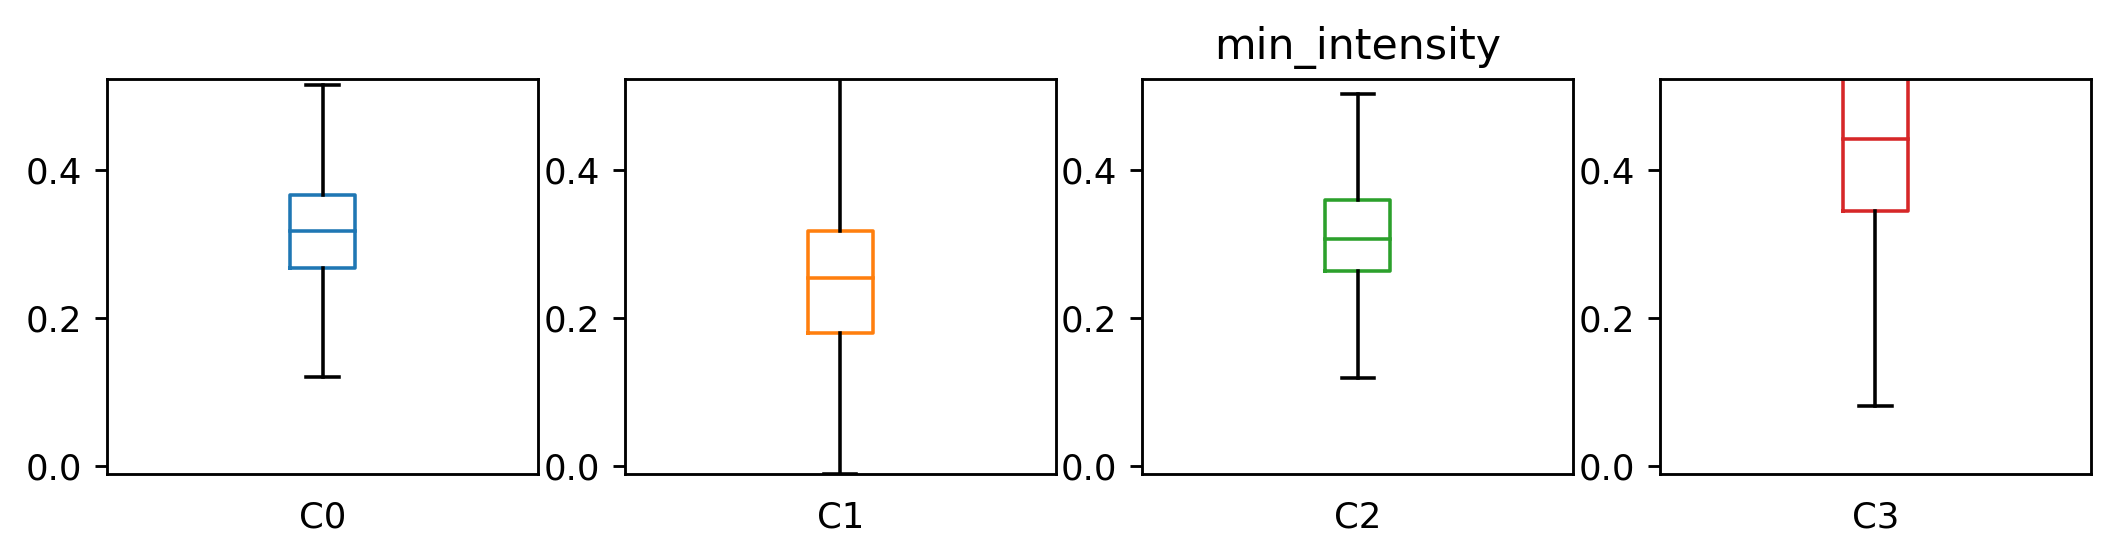

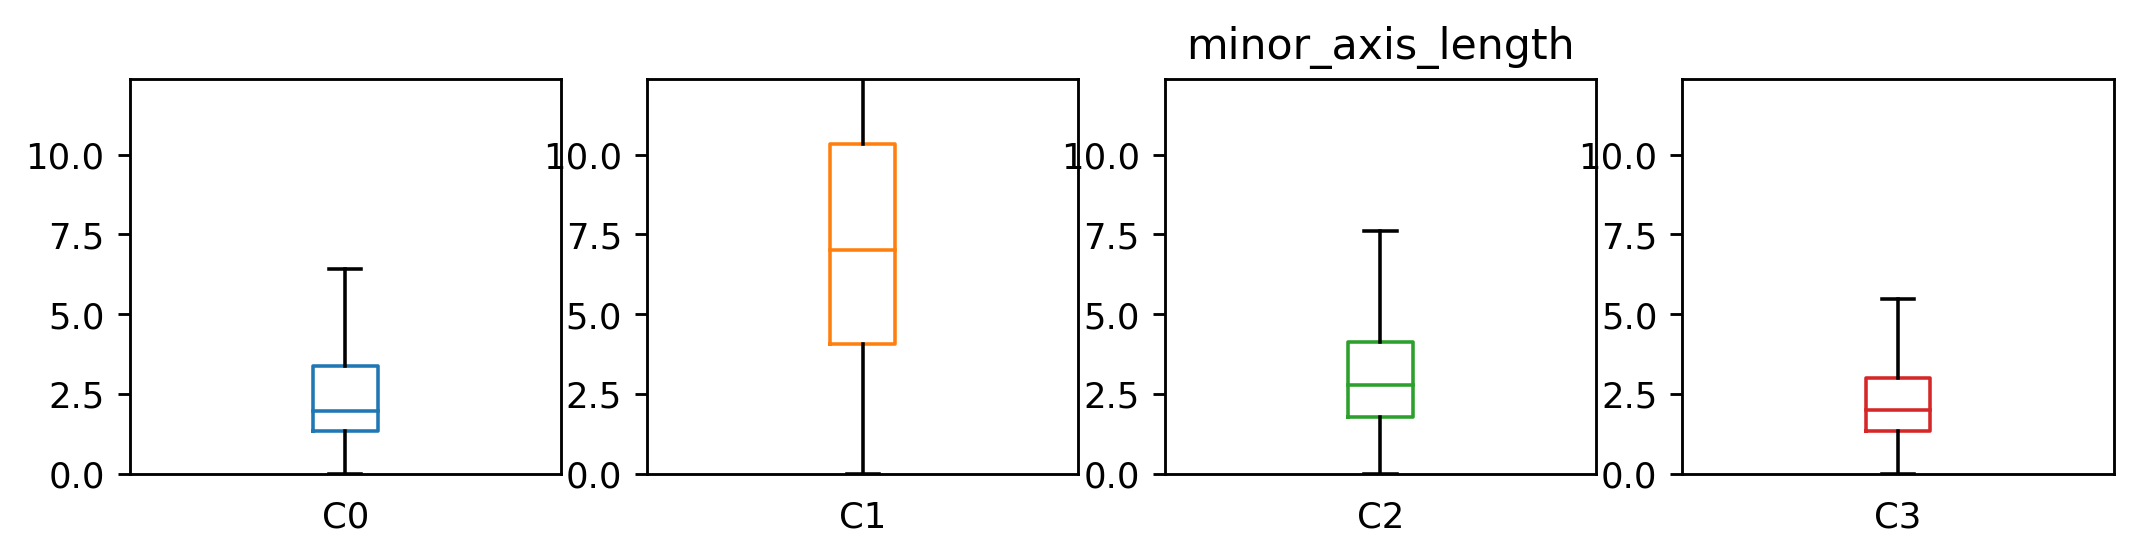

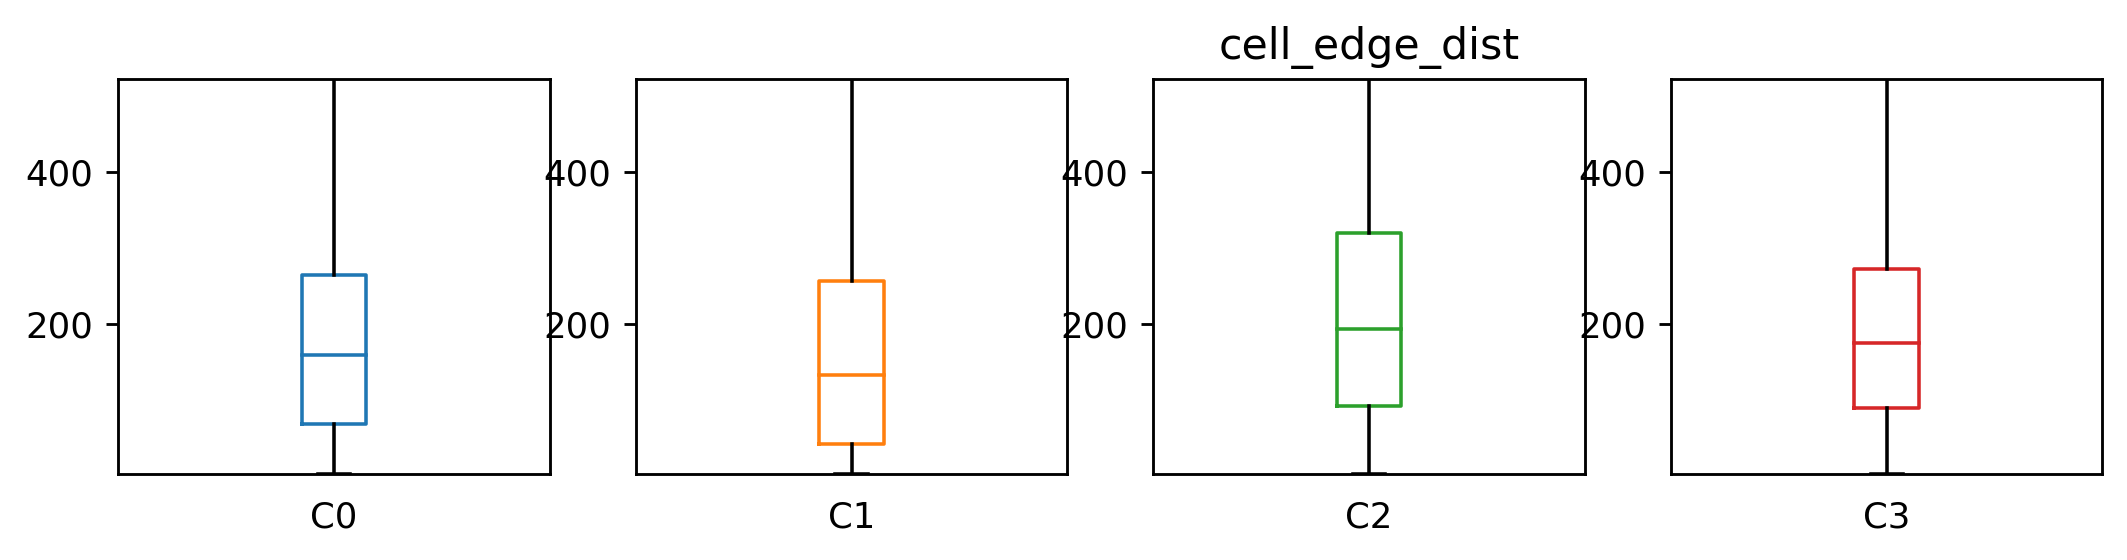

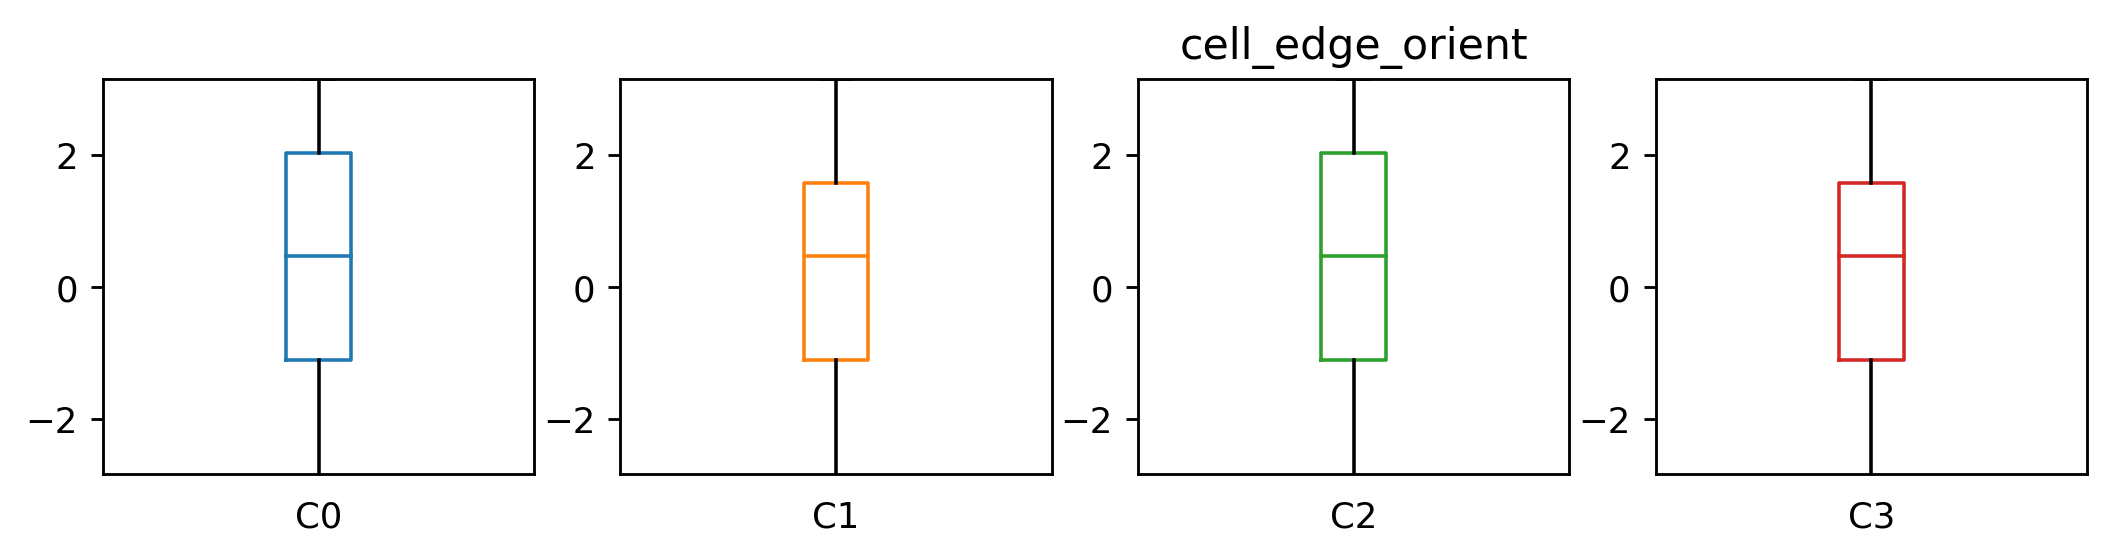

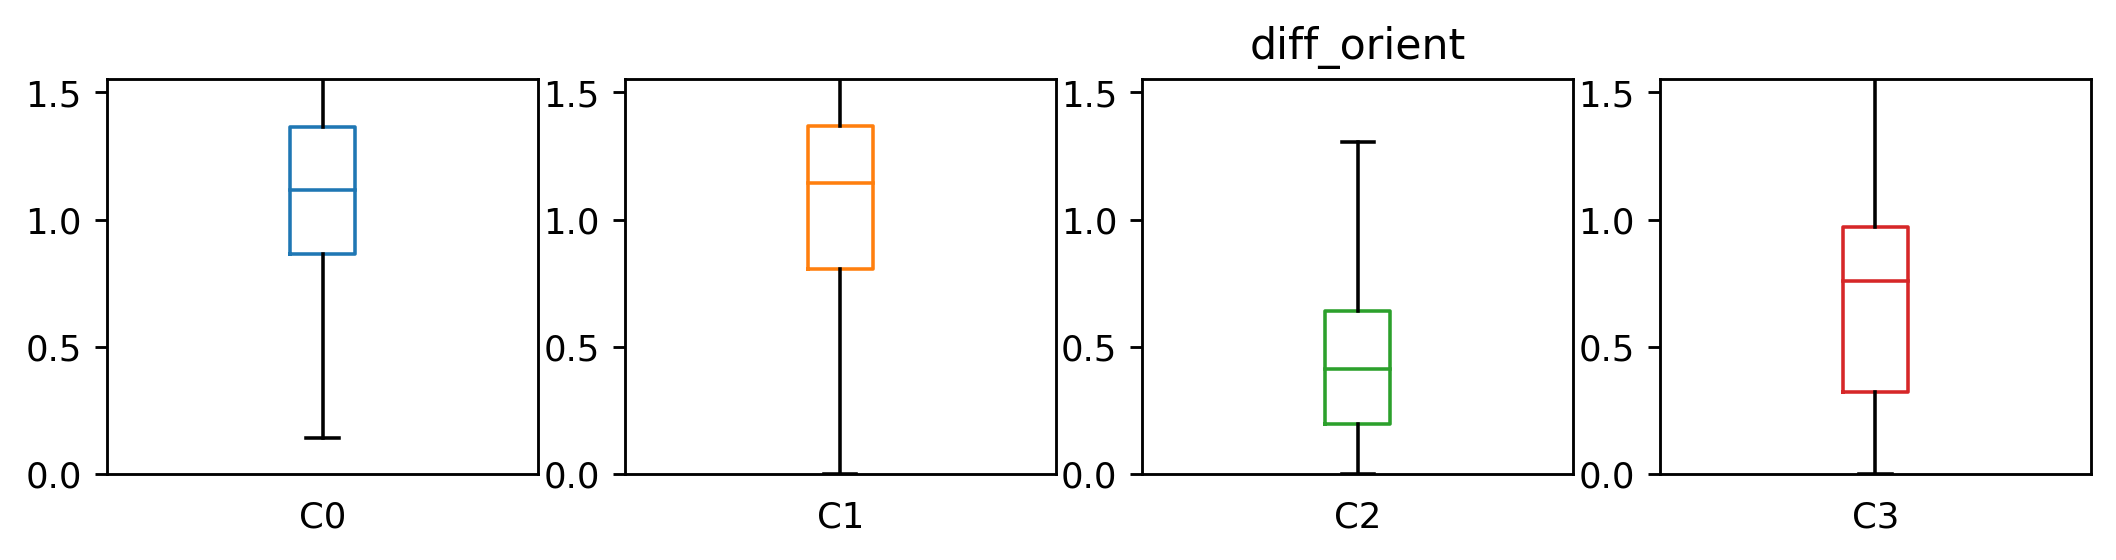

In [13]:
for clusterMed in ['MiniBatc']:
   for featureName in columns:   
        fig, ax = plt.subplots(1, 4, figsize=(10,2), dpi=256, facecolor='w', edgecolor='k')

        for i in range(4):
            AA =prop_df_pax_all[prop_df_pax_all['cluster_ID_'+clusterMed]==i]
            boxfig = ax[i].boxplot(AA[featureName],showfliers=False,boxprops={'color':newmap.colors[i+1,:]})
            ax[i].set_ylim([np.percentile(prop_df_pax_all[featureName],0.01),np.percentile(prop_df_pax_all[featureName],95)])
            ax[i].set_xlabel('C'+str(i))
            ax[i].set_xticks(())
            for median in boxfig['medians']:
                median.set_color(newmap.colors[i+1,:])
        ax[2].set_title(featureName )

        fig.savefig(os.path.join('/mnt/d/lding/FA/analysis_results/static_clustering_stats', 'pax_moredotslessfea_nc4_stat_'+featureName + '_' +clusterMed+'.png'))
            

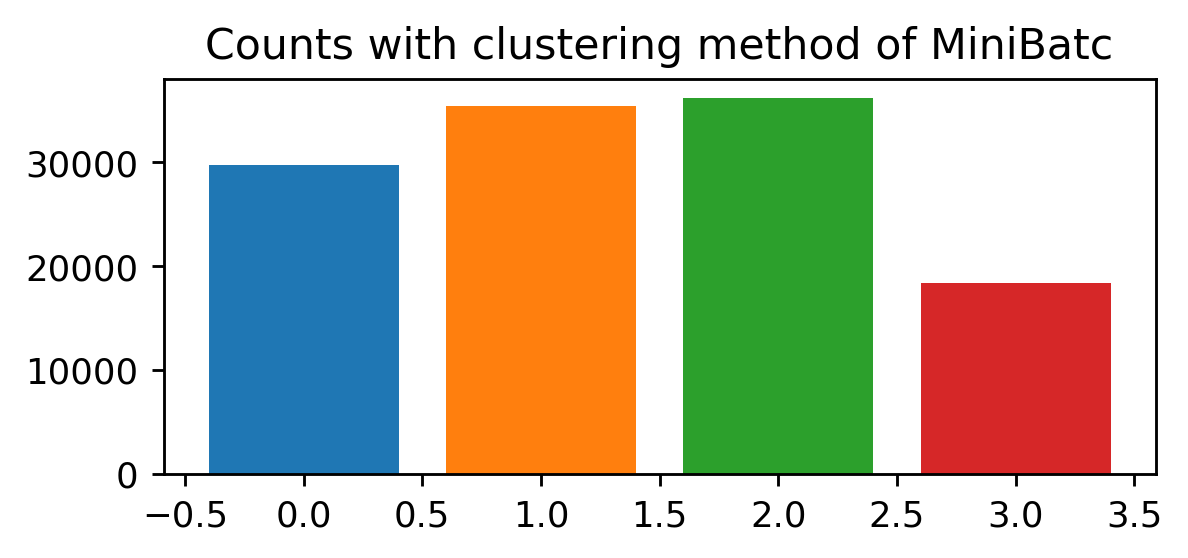

In [14]:
for clusterMed in ['MiniBatc']:
    fig = plt.figure(figsize=(5,2), dpi=256, facecolor='w', edgecolor='k')

    hist_array = np.histogram(prop_df_pax_all['cluster_ID_'+clusterMed], 4)
    plt.bar([0,1,2,3],hist_array[0],color=newmap.colors[1:5,:])

    # plt.hist(prop_df_pax_all['cluster_ID_'+clusterMed],7,color=newmap.color)    
    plt.title('Counts with clustering method of ' +clusterMed )

    fig.savefig(os.path.join('/mnt/d/lding/FA/analysis_results/static_clustering_stats', 'paxmoredotslessfa_stat_C4_no_' +clusterMed+'.png'))

In [15]:
rock_prop_df_pax_all  = prop_df_pax_all.iloc[102593:]
contrl_prop_df_pax_all  = prop_df_pax_all.iloc[0:102593]

/home/ldin/anaconda3/envs/segmentation/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


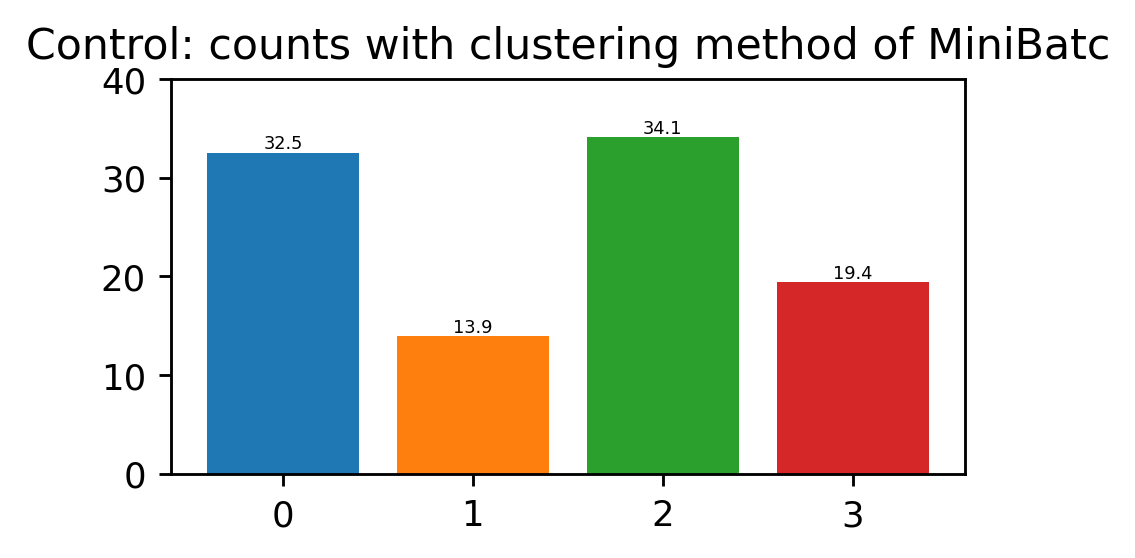

In [22]:
for clusterMed in ['MiniBatc']:
    fig = plt.figure(figsize=(4,2), dpi=256, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(1, 1, 1)
    hist_array = np.histogram(rock_prop_df_pax_all['cluster_ID_'+clusterMed],4)
    hist_array = hist_array/sum(hist_array[0])*100
    bar = plt.bar([0,1,2,3],hist_array[0],color=newmap.colors[1:5,:])
    ax.bar_label(bar, fmt='%.1f',fontsize=5)
    ax.set_ylim(0,40)

    # plt.hist(prop_df_pax_all['cluster_ID_'+clusterMed],7,color=newmap.color)    
    plt.title('Control: counts with clustering method of ' +clusterMed )

    fig.savefig(os.path.join('/mnt/d/lding/FA/analysis_results/static_clustering_stats', 'pax_moredotslessfea_rock_stat_C4_no_' +clusterMed+'.png'))

/home/ldin/anaconda3/envs/segmentation/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


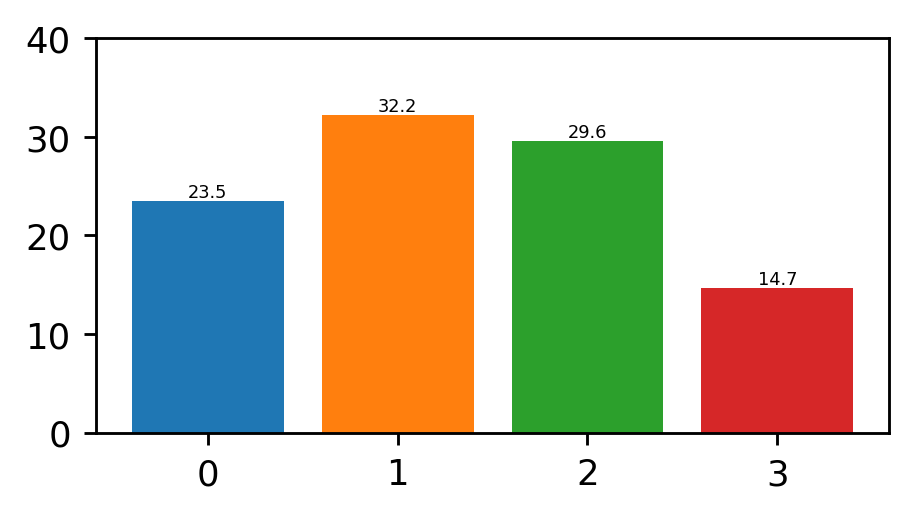

In [23]:
for clusterMed in ['MiniBatc']:
    
    fig = plt.figure(figsize=(4,2), dpi=256, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(1, 1, 1)
    hist_array = np.histogram(contrl_prop_df_pax_all['cluster_ID_'+clusterMed],4)
    hist_array = hist_array/sum(hist_array[0])*100
    bar = plt.bar([0,1,2,3],hist_array[0],color=newmap.colors[1:5,:])
    ax.bar_label(bar, fmt='%.1f',fontsize=5)
    ax.set_ylim(0,40)

    fig.savefig(os.path.join('/mnt/d/lding/FA/analysis_results/static_clustering_stats', 'pax_moredotslessfea_control_C4_stat_no_' +clusterMed+'.png'))